In [ ]:
# Задача 4.1.
# Используя стандартные средства opencv сохраните изображения сгенерированного набора данных в форматах .png, .jpg, .bmp.
# Выполните чтение сохраненных данных из файла.
# При помощи метрик SSIM, MSE сравните данные.
# Задача 4.2.1.
# Реализуйте алгоритмы downsampling:
#  - max
#  - среднее на выбор ( не average)
# Задача 4.2.2.
# Реализуйте алгоритм Ланцоша для восстановления разрешения исходного изображения.
# При помощи метрик SSIM, MSE сравните исходное изображение и восстановленное в исходном разрешении.

Генератор

In [9]:
import os
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt

def load_patches_from_folder(folder_path):

    patches = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(folder_path, filename))
            if img is not None:
                patches.append(img)
    return patches

def generate_background_from_patches(background_patches, num_patches=8, output_size=(256, 256)):

    selected_patches = random.choices(background_patches, k=num_patches)
    background = np.zeros((output_size[0], output_size[1], 3), dtype=np.uint8)
    patch_size = 128

    for i in range(0, output_size[0], patch_size):
        for j in range(0, output_size[1], patch_size):
            if selected_patches:
                patch = selected_patches.pop()

                if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                    patch = cv2.resize(patch, (patch_size, patch_size))

                try:
                    background[i:i+patch_size, j:j+patch_size] = patch
                except ValueError as e:
                    print(f"Ошибка при размещении патча: {e}")
                    continue
            else:
                break

    return background

def overlay_cells_on_background(background, cell_patches, num_cells=5):

    output = background.copy()
    for _ in range(num_cells):

        cell = random.choice(cell_patches)
        x = random.randint(0, background.shape[0] - cell.shape[0])
        y = random.randint(0, background.shape[1] - cell.shape[1])
        mask = np.zeros((cell.shape[0], cell.shape[1], 3), dtype=np.uint8)
        radius = min(cell.shape[0], cell.shape[1]) // 2
        cv2.circle(mask, (cell.shape[1] // 2, cell.shape[0] // 2), radius, (255, 255, 255), -1)
        mask = cv2.GaussianBlur(mask, (51, 51), 0)
        mask = mask.astype(np.float32) / 255.0

        for c in range(3):
            output[x:x+cell.shape[0], y:y+cell.shape[1], c] = (
                output[x:x+cell.shape[0], y:y+cell.shape[1], c] * (1 - mask[:, :, c]) +
                cell[:, :, c] * mask[:, :, c]
            )
    return output

patches_folder = '/content/patches'
background_folder = os.path.join(patches_folder, 'background')
cells_folder = os.path.join(patches_folder, 'cells')

background_patches = load_patches_from_folder(background_folder)
cell_patches = load_patches_from_folder(cells_folder)

4.1

Формат: png, MSE: 0.0, SSIM: 1.0
Формат: jpg, MSE: 1.1204681396484375, SSIM: 0.9864627526528926
Формат: bmp, MSE: 0.0, SSIM: 1.0


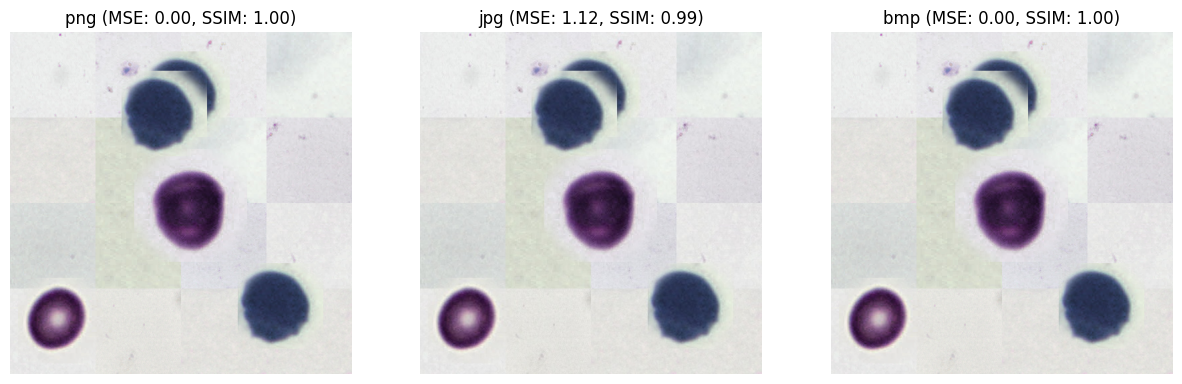

Формат: png, MSE: 0.0, SSIM: 1.0
Формат: jpg, MSE: 1.1517486572265625, SSIM: 0.9882756112391535
Формат: bmp, MSE: 0.0, SSIM: 1.0


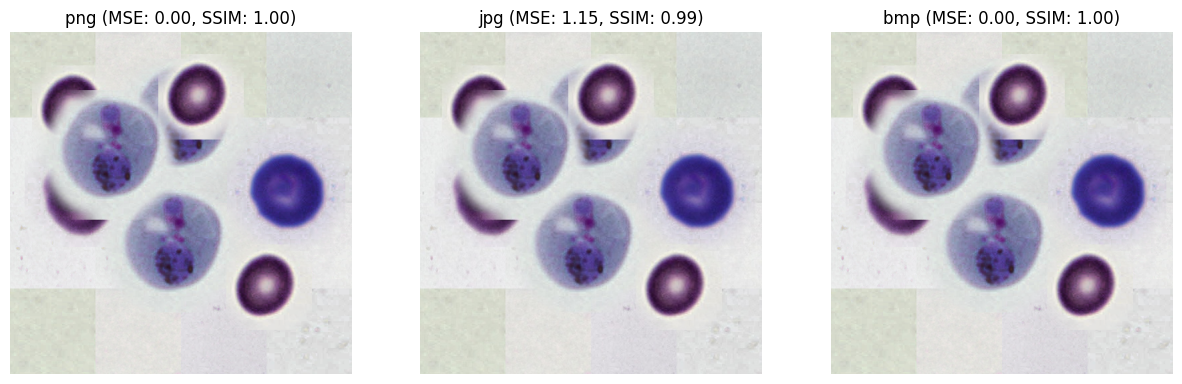

Формат: png, MSE: 0.0, SSIM: 1.0
Формат: jpg, MSE: 1.1786537170410156, SSIM: 0.9864102116600985
Формат: bmp, MSE: 0.0, SSIM: 1.0


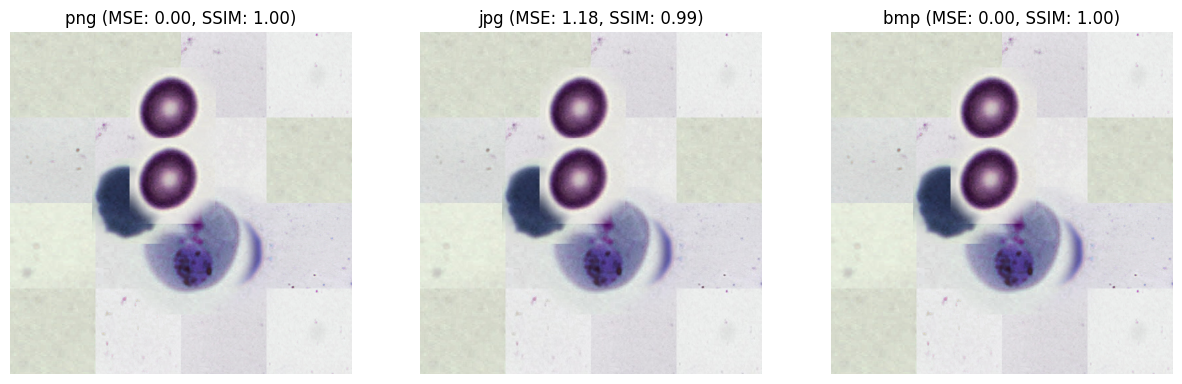

In [10]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import matplotlib.pyplot as plt

def show_images_in_row(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (image, title) in enumerate(zip(images, titles)):
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[i].set_title(title)
        axes[i].axis('off')
    plt.show()

def save_images_in_formats(image, base_filename):
    cv2.imwrite(f'{base_filename}.png', image)
    cv2.imwrite(f'{base_filename}.jpg', image)
    cv2.imwrite(f'{base_filename}.bmp', image)

def compare_images(original_image, base_filename):
    formats = ['png', 'jpg', 'bmp']
    loaded_images = []
    titles = []

    for fmt in formats:
        loaded_image = cv2.imread(f'{base_filename}.{fmt}')
        if loaded_image is None:
            print(f"Ошибка при чтении файла {base_filename}.{fmt}")
            continue

        original_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
        loaded_gray = cv2.cvtColor(loaded_image, cv2.COLOR_BGR2GRAY)

        mse_value = mean_squared_error(original_gray, loaded_gray)
        ssim_value, _ = ssim(original_gray, loaded_gray, full=True)

        print(f"Формат: {fmt}, MSE: {mse_value}, SSIM: {ssim_value}")
        loaded_images.append(loaded_image)
        titles.append(f'{fmt} (MSE: {mse_value:.2f}, SSIM: {ssim_value:.2f})')

    show_images_in_row(loaded_images, titles)

for i in range(3):
    num_patches_for_background = 16
    background = generate_background_from_patches(background_patches, num_patches=num_patches_for_background, output_size=(512, 512))
    num_cells = random.randint(3, 10)
    final_image = overlay_cells_on_background(background, cell_patches, num_cells=num_cells)

    base_filename = f'generated_image_{i+1}'
    save_images_in_formats(final_image, base_filename)
    compare_images(final_image, base_filename)

4.2

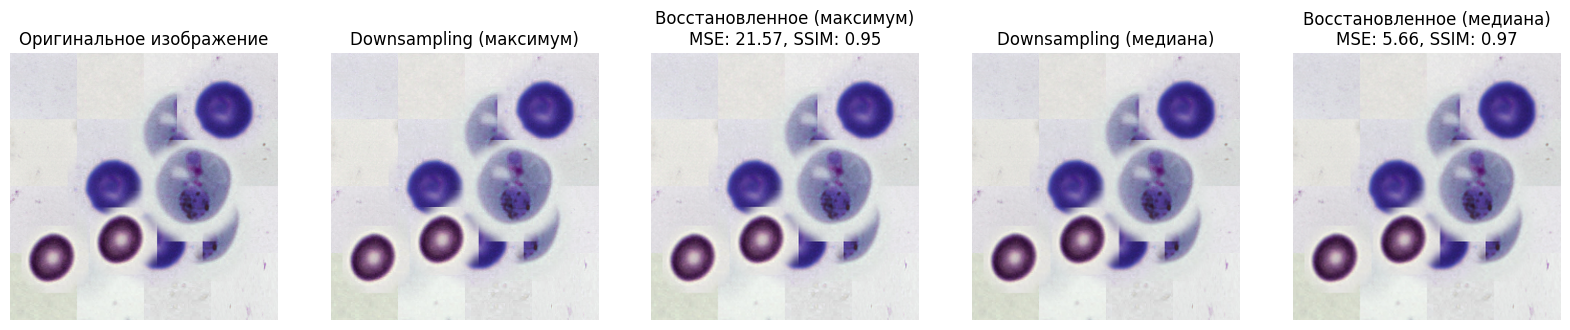

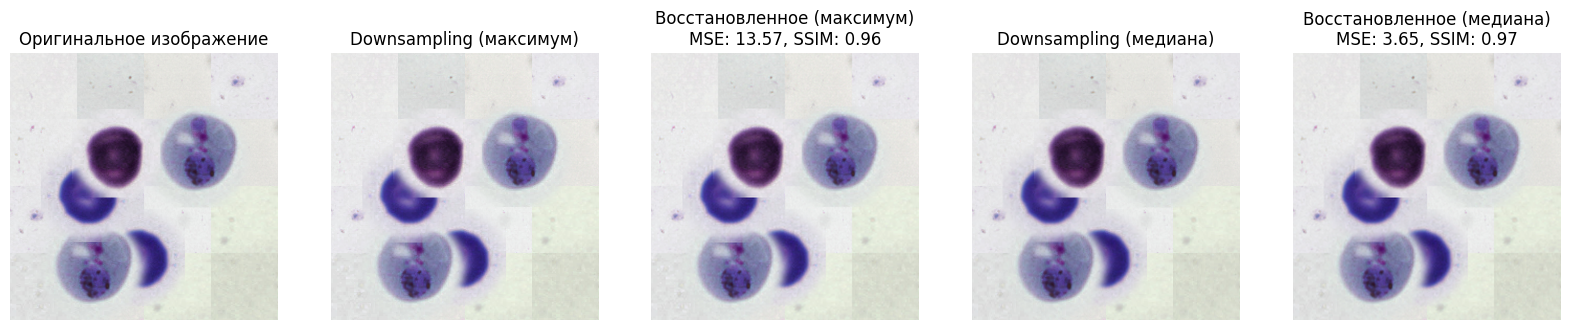

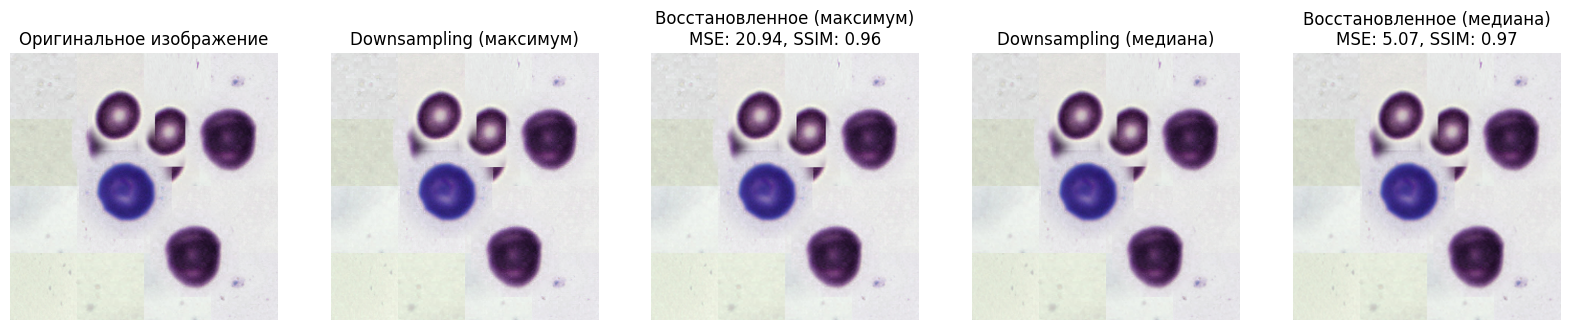

In [14]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import matplotlib.pyplot as plt

def show_images_in_row(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for i, (image, title) in enumerate(zip(images, titles)):
        axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[i].set_title(title)
        axes[i].axis('off')
    plt.show()

def max_pooling(image, pool_size):
    h, w, c = image.shape
    new_h = h // pool_size
    new_w = w // pool_size
    downsampled = np.zeros((new_h, new_w, c), dtype=np.uint8)

    for i in range(new_h):
        for j in range(new_w):
            for channel in range(c):
                downsampled[i, j, channel] = np.max(image[i*pool_size:(i+1)*pool_size, j*pool_size:(j+1)*pool_size, channel])
    return downsampled

def median_pooling(image, pool_size):
    h, w, c = image.shape
    new_h = h // pool_size
    new_w = w // pool_size
    downsampled = np.zeros((new_h, new_w, c), dtype=np.uint8)

    for i in range(new_h):
        for j in range(new_w):
            for channel in range(c):
                downsampled[i, j, channel] = np.median(image[i*pool_size:(i+1)*pool_size, j*pool_size:(j+1)*pool_size, channel])
    return downsampled

def lanczos_interpolation(image, scale_factor):
    h, w, c = image.shape
    new_h = int(h * scale_factor)
    new_w = int(w * scale_factor)
    restored_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LANCZOS4)
    return restored_image

pool_size = 2
scale_factor = 2

for i in range(3):
    num_patches_for_background = 16
    background = generate_background_from_patches(background_patches, num_patches=num_patches_for_background, output_size=(512, 512))
    num_cells = random.randint(3, 10)
    final_image = overlay_cells_on_background(background, cell_patches, num_cells=num_cells)

    downsampled_max = max_pooling(final_image, pool_size)
    downsampled_median = median_pooling(final_image, pool_size)
    restored_max = lanczos_interpolation(downsampled_max, scale_factor)
    restored_median = lanczos_interpolation(downsampled_median, scale_factor)

    original_gray = cv2.cvtColor(final_image, cv2.COLOR_BGR2GRAY)
    restored_max_gray = cv2.cvtColor(restored_max, cv2.COLOR_BGR2GRAY)
    restored_median_gray = cv2.cvtColor(restored_median, cv2.COLOR_BGR2GRAY)

    mse_max = mean_squared_error(original_gray, restored_max_gray)
    ssim_max, _ = ssim(original_gray, restored_max_gray, full=True)

    mse_median = mean_squared_error(original_gray, restored_median_gray)
    ssim_median, _ = ssim(original_gray, restored_median_gray, full=True)

    images = [
        final_image,
        downsampled_max,
        restored_max,
        downsampled_median,
        restored_median
    ]
    titles = [
        'Оригинальное изображение',
        f'Downsampling (максимум)',
        f'Восстановленное (максимум)\nMSE: {mse_max:.2f}, SSIM: {ssim_max:.2f}',
        f'Downsampling (медиана)',
        f'Восстановленное (медиана)\nMSE: {mse_median:.2f}, SSIM: {ssim_median:.2f}'
    ]
    show_images_in_row(images, titles)